# TFM CODE

Miembros del grupo:
- Lydia Díaz Garcia
- Javier de Bonilla Díaz


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Read data

In [2]:
#pip install pyarrow

In [3]:
df_train = pd.read_parquet('prosperLoanData_processed_train.parquet')
df_val = pd.read_parquet('prosperLoanData_processed_val.parquet')
df_oot = pd.read_parquet('prosperLoanData_processed_oot.parquet')

In [4]:
#drop indeterminates
df_train = df_train.loc[df_train.indeterm==False]
df_val = df_val.loc[df_val.indeterm==False]
df_oot = df_oot.loc[df_oot.indeterm==False]

In [5]:
#get the serialized data from previous session
import pickle
input_d2  = pickle.load(open('output_HW5.pkl', 'rb'))
corr_data, features = input_d2['corr_data'], input_d2['features']
df_iv, df_psi = input_d2['iv_df'], input_d2['psi_df']

In [8]:
print(df_train.DebtToIncomeRatio.unique())

[7.000e-02 2.100e-01 5.400e-01 1.400e-01 2.400e-01 6.100e-01 1.100e-01
       nan 3.900e-01 3.300e-01 2.000e-02 3.500e-01 3.100e-01 1.800e-01
 2.600e-01 8.000e-02 2.900e-01 1.500e-01 2.000e-01 3.800e-01 3.000e-02
 1.600e-01 1.700e-01 4.100e-01 1.300e-01 2.700e-01 2.200e-01 1.250e+00
 3.400e-01 1.200e-01 6.000e-02 2.500e-01 9.100e-01 1.000e-01 2.300e-01
 1.900e-01 5.000e-02 2.800e-01 6.300e-01 4.500e-01 3.000e-01 3.200e-01
 4.800e-01 5.200e-01 7.800e-01 8.000e-01 1.000e-02 4.700e-01 3.600e-01
 8.600e-01 5.500e-01 8.100e-01 4.900e-01 4.000e-01 4.400e-01 4.300e-01
 3.700e-01 9.000e-02 8.400e-01 4.000e-02 6.000e-01 5.800e-01 8.500e-01
 5.600e-01 6.700e-01 3.660e+00 4.200e-01 0.000e+00 1.550e+00 5.300e-01
 7.000e-01 5.000e-01 4.580e+00 7.500e-01 5.700e-01 5.900e-01 6.600e-01
 7.200e-01 6.200e-01 8.300e-01 6.900e-01 1.370e+00 4.600e-01 6.500e-01
 1.160e+00 6.400e-01 7.600e-01 1.030e+00 2.300e+00 2.790e+00 1.001e+01
 5.100e-01 7.100e-01 6.800e-01 1.320e+00 7.400e-01 1.090e+00 7.700e-01
 9.500

## Filter out features

### Drop highly correlated features

In [6]:
corr_data

[('CreditScoreRangeLower',
  1,
  CreditScoreRangeUpper    1.0
  Name: CreditScoreRangeLower, dtype: float64),
 ('CreditScoreRangeUpper',
  1,
  CreditScoreRangeLower    1.0
  Name: CreditScoreRangeUpper, dtype: float64),
 ('CurrentCreditLines',
  2,
  OpenCreditLines          0.958633
  OpenRevolvingAccounts    0.855161
  Name: CurrentCreditLines, dtype: float64),
 ('OpenCreditLines',
  2,
  CurrentCreditLines       0.958633
  OpenRevolvingAccounts    0.889280
  Name: OpenCreditLines, dtype: float64),
 ('TotalCreditLinespast7years',
  1,
  TotalTrades    0.944645
  Name: TotalCreditLinespast7years, dtype: float64),
 ('OpenRevolvingAccounts',
  2,
  CurrentCreditLines    0.855161
  OpenCreditLines       0.889280
  Name: OpenRevolvingAccounts, dtype: float64),
 ('TotalTrades',
  1,
  TotalCreditLinespast7years    0.944645
  Name: TotalTrades, dtype: float64),
 ('TotalProsperPaymentsBilled',
  1,
  OnTimeProsperPayments    0.986773
  Name: TotalProsperPaymentsBilled, dtype: float64),
 ('

In [7]:
#run through the iv ranking, and drop features if they are correlated with any feature with better ranking
feats_sorted = df_iv.feature.values.tolist()

def get_uncorr_feats(corr_data, feats_sorted):
    """Handles the corr_data structure, to drop highlly correlated features
    
    Args:
        corr_data: List of tuples containing the correlation info
        feats_sorted: List, with the features to be sorted / dropped
        
    Returns:
        List with the features that have no correlation
    """
    features_keep = feats_sorted[:1]
    for feat in feats_sorted[1:]:
        #capture the correlation tuple
        crr_data = [crr for crr in corr_data if crr[0] == feat]
        if len(crr_data):
            #if there is a 'hit' with a feature in features_keep, do not include it
            hit = len(set(crr_data[0][2].index.tolist()) & set(features_keep)) > 0
            if hit:
                print ('Drop: ' + feat)
            else:
                features_keep.append(feat)    
        else:
            features_keep.append(feat)
    return features_keep

features_keep = get_uncorr_feats(corr_data, feats_sorted)

Drop: CreditScoreRangeUpper
Drop: TotalProsperPaymentsBilled
Drop: OpenCreditLines
Drop: OpenRevolvingAccounts
Drop: TotalCreditLinespast7years


In [8]:
len(features), len(features_keep), len(corr_data)

(46, 41, 9)

### Drop features with low IV

In [9]:
# IV filtering with this treshold
df_iv.head()

feature        IV
31    StatedMonthlyIncome  0.128471
29            IncomeRange  0.121295
4        EmploymentStatus  0.116132
28      DebtToIncomeRatio  0.099359
34  OnTimeProsperPayments  0.084326

### IV 

In [10]:
def lowIVFeatures(df_iv, th=0.02):
    """Returns a list with the features that have an IV lower that th
    
    Args:
        df_iv: Pandas Dataframe with the feature name and their corresponding IV
        th: Threshold to be considered when filtering the features
        
    Returns:
        List with features that have an IV lower than the threshold
    """
    return df_iv.loc[df_iv["IV"]<th].feature.tolist()

In [11]:
# capture low IV features
low_iv_feats = lowIVFeatures(df_iv)
features_keep_iv = list(set(features_keep) - set(low_iv_feats))
len(features), len(features_keep), len(features_keep_iv)

(46, 41, 21)

### Drop unstable features

In [12]:
# PSI filtering with this treshold
df_psi.head()

feature       PSI
41              Recommendations  0.000000
21    PublicRecordsLast12Months  0.000000
42   InvestmentFromFriendsCount  0.000000
43  InvestmentFromFriendsAmount  0.000000
6           IsBorrowerHomeowner  0.000025

### PSI FEATURES

In [13]:
def highPSIFeatures(df_psi, TH_PSI=0.25):
    """Returns a list with the features that have a PSI higher that th
    
    Args:
        df_iv: Pandas Dataframe with the feature name and their corresponding IV
        th: Threshold to be considered when filtering the features
        
    Returns:
        List with features that have an IV lower than the threshold
    """
    return df_psi.loc[df_psi["PSI"] > TH_PSI].feature.tolist()

In [14]:
# capture high (unstable) features
high_psi_features = highPSIFeatures(df_psi)
features_keep_psi = list(set(features_keep_iv) - set(high_psi_features))
len(features), len(features_keep), len(features_keep_iv), len(features_keep_psi)

(46, 41, 21, 20)

In [15]:
features_keep_iv

['TotalProsperLoans',
 'ProsperPrincipalBorrowed',
 'IncomeRange',
 'LoanOriginalAmount',
 'InquiriesLast6Months',
 'ProsperPaymentsOneMonthPlusLate',
 'CurrentCreditLines',
 'TotalTrades',
 'ScorexChangeAtTimeOfListing',
 'StatedMonthlyIncome',
 'Occupation',
 'EmploymentStatus',
 'ProsperPrincipalOutstanding',
 'ProsperPaymentsLessThanOneMonthLate',
 'CurrentDelinquencies',
 'IncomeVerifiable',
 'BorrowerState',
 'DebtToIncomeRatio',
 'TradesOpenedLast6Months',
 'OnTimeProsperPayments',
 'CreditScoreRangeLower']

In [16]:
final_features = features_keep_psi
final_features

['TotalProsperLoans',
 'StatedMonthlyIncome',
 'ProsperPrincipalBorrowed',
 'Occupation',
 'IncomeRange',
 'ProsperPrincipalOutstanding',
 'ProsperPaymentsLessThanOneMonthLate',
 'LoanOriginalAmount',
 'InquiriesLast6Months',
 'ProsperPaymentsOneMonthPlusLate',
 'CurrentCreditLines',
 'CreditScoreRangeLower',
 'CurrentDelinquencies',
 'IncomeVerifiable',
 'TotalTrades',
 'BorrowerState',
 'DebtToIncomeRatio',
 'TradesOpenedLast6Months',
 'OnTimeProsperPayments',
 'ScorexChangeAtTimeOfListing']

## Preprocessing - Set up bucketing - "Trameado"

#### For numerical features

In [17]:
def get_bucket_numfeature(df, feat_col, n_bins, input_slider=(0., 100.)):
    """Cuts a numeric feature in 'n_bins', balacing data in percentiles
    
    Args:
        df: Pandas DataFrame with the input data
        feat_col: Name of the column with the input feature
        obj_col: Name of the column with the target 
        n_bins: Number of cuts expected
        input_slider: Range considered for the bucketing
        
    Returns:
        List with the cuts corresponding to this feature
    """
    #get the numeric input from the dual slider
    perc_sliders = [v/100. for v in input_slider]
    var_lims = df[feat_col].quantile([perc_sliders[0], perc_sliders[1]]).values
    v_min, v_max = var_lims[0], var_lims[1]
    #filter the dataset using the slider input
    df_cut = df.loc[(df[feat_col] <= v_max) & (df[feat_col] >= v_min)][[feat_col]]
    cuts = df_cut[feat_col].quantile(np.linspace(perc_sliders[0], perc_sliders[1], n_bins + 1)).values.tolist()
    cuts = sorted(list(set(cuts)))
    return cuts

def format_dummy_col(feat_col, dummy_col):
    """Handles column names for dummy data
    
    Args:
        feat_col: Name of the column with the input feature
        dummy_col: String of the dummy column 
        
    Returns:
        Dummy column with better formatting
    """
    out = dummy_col.replace("(", "")\
                   .replace("]", "")\
                   .replace(".0", "")\
                   .replace(", ", "|")
    
    return feat_col + '_' + out
    
def apply_bucketing_num(df, feat_col, cuts):
    """Applies bucketing to numerical feature
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        cuts: Cuts that will be applied to the input data
        
    Returns:
        Pandas dataframe with dummy columns
    """
    cut_col = '{}_cut'.format(feat_col)
    if len(cuts) == 2:
        cuts = [cuts[0], np.mean(cuts), cuts[1]]
    df[cut_col] = pd.cut(df[feat_col], cuts, include_lowest=True, precision=0)
    if df[cut_col].isna().any():
        df[cut_col] = df[cut_col].cat.add_categories(["NA"])
        df[cut_col] = df[cut_col].fillna("NA")
        
    dummies_df = pd.get_dummies(df[cut_col], drop_first=True)
    dummies_df.columns = [format_dummy_col(feat_col, str(col)) for col in dummies_df.columns.values.tolist()]
    
    return dummies_df

#### For categorical features

In [18]:
def get_bucket_catfeature(df, feat_col, n_bins):
    """Cuts a categorical feature in 'n_bins', keeping categories with highest volume
    
    Args:
        df: Pandas DataFrame with the input data
        feat_col: Name of the column with the input feature
        n_bins: Number of cuts expected
        
    Returns:
        List with the cuts corresponding to this feature
    """
    cuts = df.groupby(feat_col)[feat_col].count().sort_values(ascending=False)[:int(n_bins)].index.values.tolist()
    
    return cuts

def apply_bucketing_cat(df, feat_col, cuts):
    """Applies bucketing to categorical feature
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        cuts: Cuts that will be applied to the input data
        
    Returns:
        Pandas dataframe with dummy columns
    """
    cut_col = '{}_cut'.format(feat_col)
    df[cut_col] = df[feat_col]
    df.loc[~df[cut_col].isin(cuts), cut_col] = 'Other'
    if df[cut_col].isna().any():
        df[cut_col] = df[cut_col].fillna("NA")
        
    dummies_df = pd.get_dummies(df[cut_col], prefix=feat_col, drop_first=True)
    
    return dummies_df

In [19]:
#example of numerical bucketing
cuts_num = get_bucket_numfeature(df_train, 'CreditScoreRangeLower', 6)
dumm_num = apply_bucketing_num(df_train, 'CreditScoreRangeLower', cuts_num)
dumm_num[:10]

CreditScoreRangeLower_660|680  CreditScoreRangeLower_680|700  \
1                               0                              0   
2                               0                              1   
3                               0                              0   
4                               0                              0   
5                               0                              0   
6                               1                              0   
7                               0                              0   
8                               0                              0   
9                               0                              0   
10                              1                              0   

    CreditScoreRangeLower_700|720  CreditScoreRangeLower_720|760  \
1                               0                              0   
2                               0                              0   
3                               1                              0   
4                               1                              0   
5                               1                              0   
6                               0                              0   
7                               0                              1   
8                               0                              0   
9                               0                              0   
10                              0                              0   

    CreditScoreRangeLower_760|880  
1                               0  
2                               0  
3                               0  
4                               0  
5                               0  
6                               0  
7                               0  
8                               1  
9                               0  
10                              0

In [20]:
#example of categorical bucketing
cuts_cat = get_bucket_catfeature(df_train, 'Occupation', 6)
dumm_cat = apply_bucketing_cat(df_train, 'Occupation', cuts_cat)
dumm_cat[:10]

Occupation_Analyst  Occupation_Computer Programmer  Occupation_Executive  \
1                    0                               1                     0   
2                    0                               0                     0   
3                    0                               0                     0   
4                    0                               0                     0   
5                    0                               0                     0   
6                    0                               0                     0   
7                    0                               0                     0   
8                    0                               0                     0   
9                    0                               0                     0   
10                   0                               0                     1   

    Occupation_Other  Occupation_Professional  
1                  0                        0  
2                  1                        0  
3                  1                        0  
4                  0                        1  
5                  0                        1  
6                  1                        0  
7                  1                        0  
8                  1                        0  
9                  1                        0  
10                 0                        0

### Set up bucketing, then apply it

In [21]:
def get_bucket_feature(df, feat_col, n_bins=6):
    """Trains bucketing in a feature, whether if it is numerical
    or categorical
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        n_bins: Cuts that will be applied to the input data
        
    Returns:
        List with the cuts learned from the data
    """
    if df[feat_col].dtypes in (object, bool):
        cuts = get_bucket_catfeature(df, feat_col, n_bins)
    else:
        cuts = get_bucket_numfeature(df, feat_col, n_bins)
    return cuts

def get_bucketing_allfeatures(df, features, n_bins=6):
    """Trains bucketing in all given features of a dataset
    
    Args:
        df: Pandas Dataframe with the input data
        features: Features which bucketing will be learnt
        n_bins: Cuts that will be applied to the input data
        
    Returns:
        Dict, containing all features and its corresponding
        bucketing. For example:
         {'feature1': cuts1,
          'feature2': cuts2}  
    """
    out_dict = {}
    for feature in features:
        print(feature)
        cuts = get_bucket_feature(df, feature, n_bins)
        out_dict[feature] = cuts
    return out_dict

In [22]:
final_features

['TotalProsperLoans',
 'StatedMonthlyIncome',
 'ProsperPrincipalBorrowed',
 'Occupation',
 'IncomeRange',
 'ProsperPrincipalOutstanding',
 'ProsperPaymentsLessThanOneMonthLate',
 'LoanOriginalAmount',
 'InquiriesLast6Months',
 'ProsperPaymentsOneMonthPlusLate',
 'CurrentCreditLines',
 'CreditScoreRangeLower',
 'CurrentDelinquencies',
 'IncomeVerifiable',
 'TotalTrades',
 'BorrowerState',
 'DebtToIncomeRatio',
 'TradesOpenedLast6Months',
 'OnTimeProsperPayments',
 'ScorexChangeAtTimeOfListing']

In [23]:
dict_bucketing = get_bucketing_allfeatures(df_train, final_features, n_bins=4)
dict_bucketing

TotalProsperLoans
StatedMonthlyIncome
ProsperPrincipalBorrowed
Occupation
IncomeRange
ProsperPrincipalOutstanding
ProsperPaymentsLessThanOneMonthLate
LoanOriginalAmount
InquiriesLast6Months
ProsperPaymentsOneMonthPlusLate
CurrentCreditLines
CreditScoreRangeLower
CurrentDelinquencies
IncomeVerifiable
TotalTrades
BorrowerState
DebtToIncomeRatio
TradesOpenedLast6Months
OnTimeProsperPayments
ScorexChangeAtTimeOfListing


{'TotalProsperLoans': [1.0, 2.0, 7.0],
 'StatedMonthlyIncome': [0.0,
  3166.666667,
  4666.666667,
  6833.333333,
  1750002.916667],
 'ProsperPrincipalBorrowed': [1000.0, 3000.0, 5000.0, 9818.75, 57499.0],
 'Occupation': ['Other', 'Professional', 'Computer Programmer', 'Executive'],
 'IncomeRange': ['$25,000-49,999',
  '$50,000-74,999',
  '$100,000+',
  '$75,000-99,999'],
 'ProsperPrincipalOutstanding': [0.0, 869.095, 3163.4175, 22538.13],
 'ProsperPaymentsLessThanOneMonthLate': [0.0, 40.0],
 'LoanOriginalAmount': [1000.0, 3000.0, 5000.0, 8500.0, 25000.0],
 'InquiriesLast6Months': [0.0, 1.0, 2.0, 27.0],
 'ProsperPaymentsOneMonthPlusLate': [0.0, 21.0],
 'CurrentCreditLines': [0.0, 6.0, 9.0, 13.0, 56.0],
 'CreditScoreRangeLower': [600.0, 660.0, 700.0, 740.0, 880.0],
 'CurrentDelinquencies': [0.0, 24.0],
 'IncomeVerifiable': [True, False],
 'TotalTrades': [1.0, 14.0, 21.0, 30.0, 102.0],
 'BorrowerState': ['CA', 'FL', 'NY', 'TX'],
 'DebtToIncomeRatio': [0.0, 0.13, 0.19, 0.3, 10.01],
 'Trad

In [24]:
len(final_features), len(dict_bucketing.keys())

(20, 20)

In [25]:
def apply_bucketing(df, feat_col, cuts):
    """Applies a bucketing schema
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        cuts: Cuts that will be applied to the input data
        
    Returns:
        Pandas DataFrame with columns dummy columns
    """
    if df[feat_col].dtypes in (object, bool):
        df_buck = apply_bucketing_cat(df, feat_col, cuts)
    else:
        df_buck = apply_bucketing_num(df, feat_col, cuts)
    return df_buck

In [26]:
apply_bucketing(df_train, 'CreditScoreRangeLower', dict_bucketing['CreditScoreRangeLower']).head()

CreditScoreRangeLower_660|700  CreditScoreRangeLower_700|740  \
1                              0                              0   
2                              1                              0   
3                              0                              1   
4                              0                              1   
5                              0                              1   

   CreditScoreRangeLower_740|880  
1                              0  
2                              0  
3                              0  
4                              0  
5                              0

In [27]:
# Apply the bucketing

# Keep each column dummy columns in independent lists
list_df_tr, list_df_val, list_df_oot = [], [], []
for feat in final_features:
    list_df_tr.append(apply_bucketing(df_train, feat, dict_bucketing[feat]))
    list_df_val.append(apply_bucketing(df_val, feat, dict_bucketing[feat]))
    list_df_oot.append(apply_bucketing(df_oot, feat, dict_bucketing[feat]))

# Then 'vertically' combine them
df_tr_preproc = pd.concat(list_df_tr, axis=1)
df_val_preproc = pd.concat(list_df_val, axis=1)
df_oot_preproc = pd.concat(list_df_oot, axis=1)

# Capture the name of all buckets in our dataset
keep_cols_buck = df_tr_preproc.columns

In [28]:
df_tr_preproc.shape, df_oot_preproc.shape

((16806, 56), (7991, 58))

In [29]:
# Capture the target in each subset
y_tr, y_val, y_oot = df_train['bad'], df_val['bad'], df_oot['bad']

## Modeling

### Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [31]:
def get_auc(y_true, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    return metrics.auc(fpr, tpr)

In [32]:
#check buckets correlations
corr = df_tr_preproc[keep_cols_buck].corr()
orig_features = keep_cols_buck.values.tolist()
corr_TH = 0.75
n_corr_list=[]
corr_feats_list=[]
for f in orig_features:
    #get correlation entries for the feature
    corr_f = corr[f][[col for col in orig_features if col!=f]]
    #work with absolute value
    corr_f_abs = corr_f.abs()
    #get features above corr TH
    corr_ht_th = corr_f_abs[corr_f_abs>corr_TH]
    n_corr_list.append(corr_ht_th.shape[0])
    corr_feats_list.append(corr_ht_th)

corr_buckets = [(feat, n, feats_corr) for n, feats_corr, feat in zip(n_corr_list, corr_feats_list, orig_features) if n>0]
corr_buckets

[('TotalProsperLoans_NA',
  6,
  ProsperPrincipalBorrowed_NA               1.000000
  ProsperPrincipalOutstanding_NA            1.000000
  ProsperPaymentsLessThanOneMonthLate_NA    1.000000
  ProsperPaymentsOneMonthPlusLate_NA        1.000000
  OnTimeProsperPayments_NA                  1.000000
  ScorexChangeAtTimeOfListing_NA            0.996874
  Name: TotalProsperLoans_NA, dtype: float64),
 ('ProsperPrincipalBorrowed_NA',
  6,
  TotalProsperLoans_NA                      1.000000
  ProsperPrincipalOutstanding_NA            1.000000
  ProsperPaymentsLessThanOneMonthLate_NA    1.000000
  ProsperPaymentsOneMonthPlusLate_NA        1.000000
  OnTimeProsperPayments_NA                  1.000000
  ScorexChangeAtTimeOfListing_NA            0.996874
  Name: ProsperPrincipalBorrowed_NA, dtype: float64),
 ('ProsperPrincipalOutstanding_NA',
  6,
  TotalProsperLoans_NA                      1.000000
  ProsperPrincipalBorrowed_NA               1.000000
  ProsperPaymentsLessThanOneMonthLate_NA    1.0

In [33]:
glm_cols = get_uncorr_feats(corr_buckets, orig_features)

Drop: ProsperPrincipalBorrowed_NA
Drop: ProsperPrincipalOutstanding_NA
Drop: ProsperPaymentsLessThanOneMonthLate_NA
Drop: ProsperPaymentsOneMonthPlusLate_NA
Drop: DebtToIncomeRatio_NA
Drop: OnTimeProsperPayments_NA
Drop: ScorexChangeAtTimeOfListing_NA


In [34]:
glm_cols

['TotalProsperLoans_2|7',
 'TotalProsperLoans_NA',
 'StatedMonthlyIncome_3167|4667',
 'StatedMonthlyIncome_4667|6833',
 'StatedMonthlyIncome_6833|1750003',
 'ProsperPrincipalBorrowed_3000|5000',
 'ProsperPrincipalBorrowed_5000|9819',
 'ProsperPrincipalBorrowed_9819|57499',
 'Occupation_Executive',
 'Occupation_Other',
 'Occupation_Professional',
 'IncomeRange_$25,000-49,999',
 'IncomeRange_$50,000-74,999',
 'IncomeRange_$75,000-99,999',
 'IncomeRange_Other',
 'ProsperPrincipalOutstanding_869|3163',
 'ProsperPrincipalOutstanding_3163|22538',
 'ProsperPaymentsLessThanOneMonthLate_20|40',
 'LoanOriginalAmount_3000|5000',
 'LoanOriginalAmount_5000|8500',
 'LoanOriginalAmount_8500|25000',
 'InquiriesLast6Months_1|2',
 'InquiriesLast6Months_2|27',
 'ProsperPaymentsOneMonthPlusLate_10|21',
 'CurrentCreditLines_6|9',
 'CurrentCreditLines_9|13',
 'CurrentCreditLines_13|56',
 'CreditScoreRangeLower_660|700',
 'CreditScoreRangeLower_700|740',
 'CreditScoreRangeLower_740|880',
 'CurrentDelinquenci

In [35]:
#train first model
lr = LogisticRegression(solver='lbfgs', C=0.01)
lr.fit(df_tr_preproc[glm_cols], y_tr)

LogisticRegression(C=0.01)

In [36]:
df_tr_preproc[glm_cols].head()

TotalProsperLoans_2|7  TotalProsperLoans_NA  StatedMonthlyIncome_3167|4667  \
1                      0                     1                              0   
2                      0                     1                              0   
3                      0                     1                              0   
4                      0                     1                              1   
5                      0                     1                              1   

   StatedMonthlyIncome_4667|6833  StatedMonthlyIncome_6833|1750003  \
1                              1                                 0   
2                              0                                 1   
3                              0                                 0   
4                              0                                 0   
5                              0                                 0   

   ProsperPrincipalBorrowed_3000|5000  ProsperPrincipalBorrowed_5000|9819  \
1                                   0                                   0   
2                                   0                                   0   
3                                   0                                   0   
4                                   0                                   0   
5                                   0                                   0   

   ProsperPrincipalBorrowed_9819|57499  Occupation_Executive  \
1                                    0                     0   
2                                    0                     0   
3                                    0                     0   
4                                    0                     0   
5                                    0                     0   

   Occupation_Other  ...  DebtToIncomeRatio_0.1|0.2  \
1                 0  ...                          0   
2                 1  ...                          0   
3                 1  ...                          0   
4                 0  ...                          1   
5                 0  ...                          0   

   DebtToIncomeRatio_0.2|0.3  DebtToIncomeRatio_0.3|10  \
1                          0                         0   
2                          1                         0   
3                          0                         1   
4                          0                         0   
5                          1                         0   

   TradesOpenedLast6Months_1|16  OnTimeProsperPayments_10|19  \
1                             0                            0   
2                             1                            0   
3                             0                            0   
4                             0                            0   
5                             0                            0   

   OnTimeProsperPayments_19|34  OnTimeProsperPayments_34|107  \
1                            0                             0   
2                            0                             0   
3                            0                             0   
4                            0                             0   
5                            0                             0   

   ScorexChangeAtTimeOfListing_-32|-3  ScorexChangeAtTimeOfListing_-3|28  \
1                                   0                                  0   
2                                   0                                  0   
3                                   0                                  0   
4                                   0                                  0   
5                                   0                                  0   

   ScorexChangeAtTimeOfListing_28|286  
1                                   0  
2                                   0  
3                                   0  
4                                   0  
5                                   0  

[5 rows x 49 columns]

In [37]:
# Predict for all subsets
pred_log1_tr = lr.predict_proba(df_tr_preproc[glm_cols])[:, 1]
pred_log1_val = lr.predict_proba(df_val_preproc[glm_cols])[:, 1]
pred_log1_oot = lr.predict_proba(df_oot_preproc[glm_cols])[:, 1]

In [38]:
Log1_aucs = get_auc(y_tr, pred_log1_tr), get_auc(y_val, pred_log1_val), get_auc(y_oot, pred_log1_oot)
Log1_aucs

(0.7090335155138432, 0.6818628198771977, 0.691098089674039)

In [39]:
# Get p-values
# Mostly from: https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d

import scipy.stats as stat
def get_p_vals(lr, X):
    denom = (2.0*(1.0+np.cosh(lr.decision_function(X))))
    denom = np.tile(denom,(X.shape[1],1)).T
    F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
    Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
    sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
    z_scores = lr.coef_[0]/sigma_estimates # z-score for eaach model coefficient
    p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values#        
    return p_values

def show_lr_summary(p_values, features, lr):
    df_ret = pd.DataFrame({'feature': features,
                           'p_val': p_values,
                           'betas': lr.coef_.tolist()[0]})[['feature', 'betas', 'p_val']]
    return df_ret

In [40]:
# If there was any issue with the data (high correlations...)
# This would be messy, with NAs, or maybe not even able to run
p_values = get_p_vals(lr, df_tr_preproc[glm_cols])
show_lr_summary(p_values, glm_cols, lr)

feature     betas         p_val
0                       TotalProsperLoans_2|7 -0.064787  7.887020e-01
1                        TotalProsperLoans_NA  0.215851  1.315076e-01
2               StatedMonthlyIncome_3167|4667 -0.095511  2.659123e-01
3               StatedMonthlyIncome_4667|6833 -0.123123  3.384167e-01
4            StatedMonthlyIncome_6833|1750003 -0.400699  1.527466e-02
5          ProsperPrincipalBorrowed_3000|5000 -0.036953  8.046667e-01
6          ProsperPrincipalBorrowed_5000|9819  0.012872  9.345169e-01
7         ProsperPrincipalBorrowed_9819|57499 -0.070311  6.979681e-01
8                        Occupation_Executive  0.002290  9.909182e-01
9                            Occupation_Other  0.068721  6.016400e-01
10                    Occupation_Professional  0.016259  9.138318e-01
11                 IncomeRange_$25,000-49,999  0.166405  3.051898e-01
12                 IncomeRange_$50,000-74,999 -0.007139  9.628830e-01
13                 IncomeRange_$75,000-99,999 -0.097029  4.332114e-01
14                          IncomeRange_Other  0.245936  1.644644e-01
15       ProsperPrincipalOutstanding_869|3163 -0.025708  8.480191e-01
16     ProsperPrincipalOutstanding_3163|22538  0.266982  7.232363e-02
17  ProsperPaymentsLessThanOneMonthLate_20|40  0.009010  9.927675e-01
18               LoanOriginalAmount_3000|5000  0.241049  4.628249e-04
19               LoanOriginalAmount_5000|8500  0.043198  6.088147e-01
20              LoanOriginalAmount_8500|25000  0.037455  6.698694e-01
21                   InquiriesLast6Months_1|2  0.209796  7.925586e-03
22                  InquiriesLast6Months_2|27  0.438607  3.347014e-09
23      ProsperPaymentsOneMonthPlusLate_10|21 -0.003763  9.982442e-01
24                     CurrentCreditLines_6|9 -0.063239  4.021544e-01
25                    CurrentCreditLines_9|13 -0.155580  7.887108e-02
26                   CurrentCreditLines_13|56 -0.101413  3.295744e-01
27              CreditScoreRangeLower_660|700 -0.087709  1.980002e-01
28              CreditScoreRangeLower_700|740 -0.244496  1.788969e-03
29              CreditScoreRangeLower_740|880 -0.457975  7.514044e-07
30                 CurrentDelinquencies_12|24  0.031663  9.678296e-01
31                      IncomeVerifiable_True -0.440620  2.542678e-06
32                          TotalTrades_14|21 -0.048386  5.312031e-01
33                          TotalTrades_21|30 -0.105031  2.165006e-01
34                         TotalTrades_30|102 -0.039483  6.827714e-01
35                           BorrowerState_FL  0.159769  1.990529e-01
36                           BorrowerState_NY -0.035263  7.890250e-01
37                        BorrowerState_Other  0.048037  5.649898e-01
38                           BorrowerState_TX -0.010912  9.353067e-01
39                  DebtToIncomeRatio_0.1|0.2 -0.076933  3.813425e-01
40                  DebtToIncomeRatio_0.2|0.3  0.008068  9.264742e-01
41                   DebtToIncomeRatio_0.3|10  0.210642  2.727251e-02
42               TradesOpenedLast6Months_1|16  0.373422  6.288121e-08
43                OnTimeProsperPayments_10|19 -0.200981  1.687727e-01
44                OnTimeProsperPayments_19|34 -0.161872  2.826443e-01
45               OnTimeProsperPayments_34|107 -0.226399  1.674233e-01
46         ScorexChangeAtTimeOfListing_-32|-3 -0.082980  5.470045e-01
47          ScorexChangeAtTimeOfListing_-3|28 -0.154085  2.908018e-01
48         ScorexChangeAtTimeOfListing_28|286 -0.198557  2.129176e-01

#### P-value based feature selection

In [41]:
# remove each bucket with the highest p-value N times
# assess how the AUC changes
N_iterations = len(glm_cols) - 3
glm_cols_pvals = [c for c in glm_cols]

# keep the AUCs in each interation 
auc_train, auc_val, auc_oot = [], [], []
# List of tuples where all selected features status will 
# be stored per iteration
features_it_pval = []

# for each iteration
for it in range(N_iterations):
    #capture the feature to be dropped
    #in the first iteration we are using the p_values from the model trained 'outside'
    feat_drop = [feat for feat, p in zip(glm_cols_pvals, p_values) if p == max(p_values)][0]
    glm_cols_pvals.remove(feat_drop)
    #re-train the model
    lr_it = LogisticRegression(solver='lbfgs', C=0.01)
    lr_it.fit(df_tr_preproc[glm_cols_pvals], y_tr)
    # Predict for all subsets
    pred_tr = lr_it.predict_proba(df_tr_preproc[glm_cols_pvals])[:, 1]
    pred_val = lr_it.predict_proba(df_val_preproc[glm_cols_pvals])[:, 1]
    pred_oot = lr_it.predict_proba(df_oot_preproc[glm_cols_pvals])[:, 1]
    #get aucs
    auc_train.append(get_auc(y_tr, pred_tr))
    auc_val.append(get_auc(y_val, pred_val)) 
    auc_oot.append(get_auc(y_oot, pred_oot))
    #get p-values
    p_values = get_p_vals(lr_it, df_tr_preproc[glm_cols_pvals])
    #keep features status at iteration
    features_it_pval.append((it, [c for c in glm_cols_pvals]))

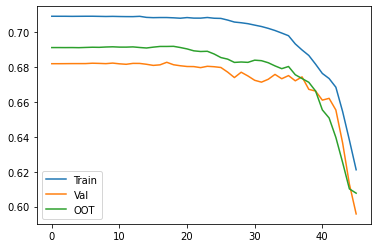

In [42]:
# Plot AUCs in each iteration
iterations = [i for i in range(N_iterations)]
plt.plot(iterations, auc_train, label='Train')
plt.plot(iterations, auc_val, label='Val')
plt.plot(iterations, auc_oot, label='OOT')
plt.legend()

In [43]:
# At iteration 40 more or less it stays stable
final_features_bucketing = [feats for it, feats in features_it_pval if it==26][0]
# Train the final model with the interesting buckets
lr_final = LogisticRegression(solver='lbfgs', C=0.01)
lr_final.fit(df_tr_preproc[final_features_bucketing], y_tr)

LogisticRegression(C=0.01)

In [44]:
df_tr_preproc[final_features_bucketing].head()

TotalProsperLoans_NA  StatedMonthlyIncome_4667|6833  \
1                     1                              1   
2                     1                              0   
3                     1                              0   
4                     1                              0   
5                     1                              0   

   StatedMonthlyIncome_6833|1750003  IncomeRange_$25,000-49,999  \
1                                 0                           0   
2                                 1                           0   
3                                 0                           1   
4                                 0                           1   
5                                 0                           1   

   IncomeRange_Other  ProsperPrincipalOutstanding_3163|22538  \
1                  0                                       0   
2                  0                                       0   
3                  0                                       0   
4                  0                                       0   
5                  0                                       0   

   LoanOriginalAmount_3000|5000  InquiriesLast6Months_1|2  \
1                             1                         1   
2                             0                         0   
3                             0                         0   
4                             0                         0   
5                             0                         0   

   InquiriesLast6Months_2|27  CurrentCreditLines_9|13  ...  \
1                          0                        0  ...   
2                          1                        0  ...   
3                          0                        0  ...   
4                          0                        1  ...   
5                          0                        1  ...   

   CreditScoreRangeLower_740|880  IncomeVerifiable_True  TotalTrades_21|30  \
1                              0                      1                  1   
2                              0                      1                  0   
3                              0                      1                  0   
4                              0                      1                  1   
5                              0                      1                  0   

   BorrowerState_FL  DebtToIncomeRatio_0.3|10  TradesOpenedLast6Months_1|16  \
1                 0                         0                             0   
2                 0                         0                             1   
3                 0                         1                             0   
4                 0                         0                             0   
5                 0                         0                             0   

   OnTimeProsperPayments_10|19  OnTimeProsperPayments_19|34  \
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   
5                            0                            0   

   OnTimeProsperPayments_34|107  ScorexChangeAtTimeOfListing_28|286  
1                             0                                   0  
2                             0                                   0  
3                             0                                   0  
4                             0                                   0  
5                             0                                   0  

[5 rows x 22 columns]

In [45]:
# Predict for all subsets
pred_tr = lr_final.predict_proba(df_tr_preproc[final_features_bucketing])[:, 1]
pred_val = lr_final.predict_proba(df_val_preproc[final_features_bucketing])[:, 1]
pred_oot = lr_final.predict_proba(df_oot_preproc[final_features_bucketing])[:, 1]

Log2_aucs = get_auc(y_tr, pred_tr), get_auc(y_val, pred_val), get_auc(y_oot, pred_oot)

In [46]:
p_values = get_p_vals(lr_final, df_tr_preproc[final_features_bucketing])
show_lr_summary(p_values, final_features_bucketing, lr_final)

feature     betas         p_val
0                     TotalProsperLoans_NA  0.279738  1.379424e-03
1            StatedMonthlyIncome_4667|6833 -0.115190  2.046180e-01
2         StatedMonthlyIncome_6833|1750003 -0.411762  2.516873e-05
3               IncomeRange_$25,000-49,999  0.187477  2.149834e-02
4                        IncomeRange_Other  0.301597  2.547720e-03
5   ProsperPrincipalOutstanding_3163|22538  0.258733  2.152837e-02
6             LoanOriginalAmount_3000|5000  0.226737  4.806215e-05
7                 InquiriesLast6Months_1|2  0.202760  9.688438e-03
8                InquiriesLast6Months_2|27  0.427018  4.506363e-09
9                  CurrentCreditLines_9|13 -0.127872  5.871483e-02
10           CreditScoreRangeLower_660|700 -0.083999  2.060743e-01
11           CreditScoreRangeLower_700|740 -0.244730  1.133305e-03
12           CreditScoreRangeLower_740|880 -0.461212  1.485419e-07
13                   IncomeVerifiable_True -0.457491  2.326896e-10
14                       TotalTrades_21|30 -0.093831  1.504283e-01
15                        BorrowerState_FL  0.143871  1.531674e-01
16                DebtToIncomeRatio_0.3|10  0.204181  2.781909e-03
17            TradesOpenedLast6Months_1|16  0.361589  7.850320e-08
18             OnTimeProsperPayments_10|19 -0.214234  1.099136e-01
19             OnTimeProsperPayments_19|34 -0.177534  1.838304e-01
20            OnTimeProsperPayments_34|107 -0.251239  5.704669e-02
21      ScorexChangeAtTimeOfListing_28|286 -0.177265  1.942798e-01

#### AUC based feature selection

In [47]:
# Try to remove all available features.
# Remove the feature that has the lowest impact in AUC
N_iterations = len(glm_cols) - 3
glm_cols_auc = [c for c in glm_cols]

auc_train, auc_val, auc_oot = [], [], []
features_it_auc = []
for it in range(N_iterations):
    print('Working for iteration: {}'.format(str(it)))
    #re-train the model
    lr_it = LogisticRegression(solver='lbfgs', C=0.01)
    lr_it.fit(df_tr_preproc[glm_cols_auc], y_tr)
    # Predict for all subsets
    pred_tr = lr_it.predict_proba(df_tr_preproc[glm_cols_auc])[:, 1]
    pred_val = lr_it.predict_proba(df_val_preproc[glm_cols_auc])[:, 1]
    pred_oot = lr_it.predict_proba(df_oot_preproc[glm_cols_auc])[:, 1]
    #get base aucs
    auc_train_it, auc_val_it, auc_oot_it = get_auc(y_tr, pred_tr), get_auc(y_val, pred_val), get_auc(y_oot, pred_oot)
    auc_train.append(auc_train_it)
    auc_val.append(auc_val_it) 
    auc_oot.append(auc_oot_it)
    #set up minimum gap
    min_gap = 500
    for feat_eval in glm_cols_auc:
        #use validation AUC only as evaluation metric
        #keep features in iteration it, but the feature under evaluation
        glm_cols_auc_ev = [c for c in glm_cols_auc if c!=feat_eval]
        lr_it_ev = LogisticRegression(solver='lbfgs', C=0.01)
        lr_it_ev.fit(df_tr_preproc[glm_cols_auc_ev], y_tr)
        #predit @ val data
        pred_val = lr_it_ev.predict_proba(df_val_preproc[glm_cols_auc_ev])[:, 1]
        #get auc @ val
        auc_val_it_ev = get_auc(y_val, pred_val)
        #check gap
        gap_val_auc = auc_val_it - auc_val_it_ev
        #capture the feature that has the lowest AUC impact
        if gap_val_auc < min_gap:
            candidate_drop = feat_eval
            min_gap = gap_val_auc
    #remove from the feature set the selected feature
    glm_cols_auc.remove(candidate_drop)
    #keep features status at iteration
    features_it_auc.append((it, [c for c in glm_cols_auc]))

Working for iteration: 0
Working for iteration: 1
Working for iteration: 2
Working for iteration: 3
Working for iteration: 4
Working for iteration: 5
Working for iteration: 6
Working for iteration: 7
Working for iteration: 8
Working for iteration: 9
Working for iteration: 10
Working for iteration: 11
Working for iteration: 12
Working for iteration: 13
Working for iteration: 14
Working for iteration: 15
Working for iteration: 16
Working for iteration: 17
Working for iteration: 18
Working for iteration: 19
Working for iteration: 20
Working for iteration: 21
Working for iteration: 22
Working for iteration: 23
Working for iteration: 24
Working for iteration: 25
Working for iteration: 26
Working for iteration: 27
Working for iteration: 28
Working for iteration: 29
Working for iteration: 30
Working for iteration: 31
Working for iteration: 32
Working for iteration: 33
Working for iteration: 34
Working for iteration: 35
Working for iteration: 36
Working for iteration: 37
Working for iteration:

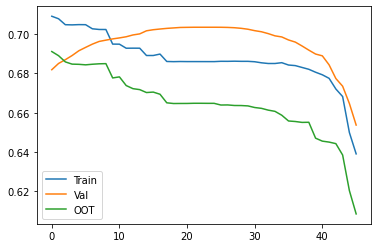

In [48]:
# Plot AUCs in each iteration
iterations = [i for i in range(N_iterations)]
plt.plot(iterations, auc_train, label='Train')
plt.plot(iterations, auc_val, label='Val')
plt.plot(iterations, auc_oot, label='OOT')
plt.legend()

In [49]:
# get the iteration where it stays stable
final_features_bucketing_auc = [feats for it, feats in features_it_auc if it==26][0]
# Train the final model with the interesting buckets
lr_final_auc = LogisticRegression(solver='lbfgs', C=0.01)
lr_final_auc.fit(df_tr_preproc[final_features_bucketing_auc], y_tr)

LogisticRegression(C=0.01)

In [50]:
# Predict for all subsets
pred_tr = lr_final_auc.predict_proba(df_tr_preproc[final_features_bucketing_auc])[:, 1]
pred_val = lr_final_auc.predict_proba(df_val_preproc[final_features_bucketing_auc])[:, 1]
pred_oot = lr_final_auc.predict_proba(df_oot_preproc[final_features_bucketing_auc])[:, 1]

Log3_aucs = get_auc(y_tr, pred_tr), get_auc(y_val, pred_val), get_auc(y_oot, pred_oot)

#### Gain Table

In [51]:
n_buckets=10
df = df_oot
pred = pred_oot

df['pred'] = pred
pred_cuts = df['pred'].quantile(np.linspace(0, 1, num = n_buckets + 1))
df['pred_cut'] = pd.cut(df['pred'], pred_cuts, include_lowest=True, duplicates='drop')

In [52]:
df_agg = df.groupby('pred_cut').agg({'pred': 'mean',
                            'bad': ['sum', 'mean'],
                            'pred_cut': 'count'})

df_agg.columns = ["avg_pred", "N_bad", "BR", "N"]
df_agg["N_good"] = df_agg["N"] - df_agg["N_bad"]
df_agg["N_bad_acum"] = df_agg["N_bad"].cumsum()
df_agg["pct_bad_acum"] = df_agg["N_bad_acum"] / df_agg["N_bad"].sum()
df_agg["pct_approv_acum"] = df_agg["N"].cumsum() / df_agg["N"].sum()
df_agg

avg_pred  N_bad        BR    N  N_good  \
pred_cut                                                                 
(0.018199999999999997, 0.0511]  0.042464     20  0.024722  809     789   
(0.0511, 0.0631]                0.057486     36  0.045570  790     754   
(0.0631, 0.0726]                0.067977     40  0.050063  799     759   
(0.0726, 0.0824]                0.077246     42  0.052500  800     758   
(0.0824, 0.0926]                0.088015     68  0.085213  798     730   
(0.0926, 0.103]                 0.098034     73  0.091022  802     729   
(0.103, 0.111]                  0.106972     81  0.101631  797     716   
(0.111, 0.125]                  0.117421     96  0.120301  798     702   
(0.125, 0.142]                  0.132422    102  0.126238  808     706   
(0.142, 0.274]                  0.167931    153  0.193671  790     637   

                                N_bad_acum  pct_bad_acum  pct_approv_acum  
pred_cut                                                                   
(0.018199999999999997, 0.0511]          20      0.028129         0.101239  
(0.0511, 0.0631]                        56      0.078762         0.200100  
(0.0631, 0.0726]                        96      0.135021         0.300088  
(0.0726, 0.0824]                       138      0.194093         0.400200  
(0.0824, 0.0926]                       206      0.289733         0.500063  
(0.0926, 0.103]                        279      0.392405         0.600425  
(0.103, 0.111]                         360      0.506329         0.700163  
(0.111, 0.125]                         456      0.641350         0.800025  
(0.125, 0.142]                         558      0.784810         0.901139  
(0.142, 0.274]                         711      1.000000         1.000000

In [53]:
# Tabla de eficiencia / Gain table
def get_gain_table(pred, df, col_target='bad', n_buckets=10):
    """Generate the gain table given a population, and its predictions
    
    Args:
        pred: np.array / pd.Series containing predictions
        df: Pandas DataFrame containing the population to be assesed
        col_target: Name of the target column
        n_buckets: Number of buckets for the gain table
        
    Returns:
        Pandas DataFrame representing the gain table
    """
    df['pred'] = pred
    pred_cuts = df['pred'].quantile(np.linspace(0, 1, num = n_buckets + 1))
    df['pred_cut'] = pd.cut(df['pred'], pred_cuts, include_lowest=True, duplicates='drop')
    
    #df['pred_cut'] = pd.qcut(df['pred'], n_buckets + 1)

    gain_table = df.groupby('pred_cut').agg({'pred': 'mean',
                                              col_target: ['mean', 'sum'],
                                             'pred_cut': 'size'})

    gain_table.columns = ['avg_pred', 'BR', 'N_bads', 'N']
    gain_table['N_goods'] = gain_table['N'] - gain_table['N_bads']
    gain_table['pct_bad_acum'] = 100. * gain_table['N_bads'].cumsum() / gain_table['N_bads'].sum()
    gain_table['pct_approv_acum'] = 100. * gain_table['N'].cumsum() / gain_table['N'].sum()
    gain_table
    
    return gain_table
# gain table for OOT sample
get_gain_table(pred_oot, df_oot)

avg_pred        BR  N_bads    N  N_goods  \
pred_cut                                                                   
(0.018199999999999997, 0.0511]  0.042464  0.024722      20  809      789   
(0.0511, 0.0631]                0.057486  0.045570      36  790      754   
(0.0631, 0.0726]                0.067977  0.050063      40  799      759   
(0.0726, 0.0824]                0.077246  0.052500      42  800      758   
(0.0824, 0.0926]                0.088015  0.085213      68  798      730   
(0.0926, 0.103]                 0.098034  0.091022      73  802      729   
(0.103, 0.111]                  0.106972  0.101631      81  797      716   
(0.111, 0.125]                  0.117421  0.120301      96  798      702   
(0.125, 0.142]                  0.132422  0.126238     102  808      706   
(0.142, 0.274]                  0.167931  0.193671     153  790      637   

                                pct_bad_acum  pct_approv_acum  
pred_cut                                                       
(0.018199999999999997, 0.0511]      2.812940        10.123889  
(0.0511, 0.0631]                    7.876231        20.010011  
(0.0631, 0.0726]                   13.502110        30.008760  
(0.0726, 0.0824]                   19.409283        40.020023  
(0.0824, 0.0926]                   28.973277        50.006257  
(0.0926, 0.103]                    39.240506        60.042548  
(0.103, 0.111]                     50.632911        70.016268  
(0.111, 0.125]                     64.135021        80.002503  
(0.125, 0.142]                     78.481013        90.113878  
(0.142, 0.274]                    100.000000       100.000000

In [54]:
# gain table for training sample
get_gain_table(pred_tr, df_train)

avg_pred        BR  N_bads     N  N_goods  pct_bad_acum  \
pred_cut                                                                    
(0.0161, 0.0475]  0.039404  0.020226      34  1681     1647      2.126329   
(0.0475, 0.0611]  0.054886  0.032719      55  1681     1626      5.565979   
(0.0611, 0.0702]  0.066047  0.047957      81  1689     1608     10.631645   
(0.0702, 0.0803]  0.075228  0.063577     107  1683     1576     17.323327   
(0.0803, 0.0918]  0.086216  0.068650     120  1748     1628     24.828018   
(0.0918, 0.102]   0.096983  0.114785     184  1603     1419     36.335210   
(0.102, 0.112]    0.106729  0.101956     172  1687     1515     47.091932   
(0.112, 0.126]    0.118149  0.127914     214  1673     1459     60.475297   
(0.126, 0.148]    0.135320  0.179941     305  1695     1390     79.549719   
(0.148, 0.296]    0.173521  0.196279     327  1666     1339    100.000000   

                  pct_approv_acum  
pred_cut                           
(0.0161, 0.0475]        10.002380  
(0.0475, 0.0611]        20.004760  
(0.0611, 0.0702]        30.054742  
(0.0702, 0.0803]        40.069023  
(0.0803, 0.0918]        50.470070  
(0.0918, 0.102]         60.008330  
(0.102, 0.112]          70.046412  
(0.112, 0.126]          80.001190  
(0.126, 0.148]          90.086874  
(0.148, 0.296]         100.000000

### Random Forest

In [55]:
# Lighther preprocessing
# Handle NAs @ numeric features
# fill with a value lower than its minimum
# We can reuse previopus categorical preprocessing

dtypes = df_train[final_features].dtypes
cat_features = df_train[final_features].select_dtypes(include=["bool", "object"]).columns.tolist()
num_feats = [f for f in final_features if f not in cat_features]

def get_nafill_rf_num(df, num_features, gap_min=1e6):
    """Get a dictionary, that will store the value that will be used 
    to fill NAs in numeric data.
    
    Args:
        df: Pandas Dataframe with the input data
        num_features: List with the names of categorical features
        gap_min: Gap between minimum value and filling value
        
    Returns:
        Dictionary, with the following structure:
        {feature1: fill_val1,
         feature2: fill_val2}
    """
    dict_fill = {}
    for num_feat in num_features:
        dict_fill[num_feat] = df[num_feat].min() - gap_min
    return dict_fill
    

def apply_nafill_rf_num(df, dict_fillrf):
    """Given a dictionary with the values to be used in NA filling,
    use it to fill NAs.
    
    Args:
        df: Pandas Dataframe with the input data
        dict_fillrf: Dictionary, that stores filling values
        
    Returns:
        Pandas Dataframe with NA being filled
    """
    df_out = df.copy()
    for num_feat in dict_fillrf.keys():
        df_out.loc[df_out[num_feat].isna(), num_feat] = dict_fillrf[num_feat]
    return df_out

In [56]:
#get dictionary to fill values from train
dict_nafill = get_nafill_rf_num(df_train, num_feats)
#apply it to train, val and oot
df_train_fill = apply_nafill_rf_num(df_train, dict_nafill)
df_val_fill = apply_nafill_rf_num(df_val, dict_nafill)
df_oot_fill = apply_nafill_rf_num(df_oot, dict_nafill)

In [57]:
cat_features

['Occupation', 'IncomeRange', 'IncomeVerifiable', 'BorrowerState']

In [58]:
# Keep each column dummy columns in independednt lists
# Initialize with the numeric data already filled
list_df_tr, list_df_val, list_df_oot = [df_train_fill[num_feats]], [df_val_fill[num_feats]], [df_oot_fill[num_feats]]
# Add the bucketing results of categorical data
for feat in cat_features:
    list_df_tr.append(apply_bucketing(df_train, feat, dict_bucketing[feat]))
    list_df_val.append(apply_bucketing(df_val, feat, dict_bucketing[feat]))
    list_df_oot.append(apply_bucketing(df_oot, feat, dict_bucketing[feat]))

# Then combine them column-wise
df_tr_preproc_rf = pd.concat(list_df_tr, axis=1)
df_val_preproc_rf = pd.concat(list_df_val, axis=1)
df_oot_preproc_rf = pd.concat(list_df_oot, axis=1)

# Keep the final column names
keep_cols_rf = df_tr_preproc_rf.columns

In [59]:
df_tr_preproc_rf.columns

Index(['TotalProsperLoans', 'StatedMonthlyIncome', 'ProsperPrincipalBorrowed',
       'ProsperPrincipalOutstanding', 'ProsperPaymentsLessThanOneMonthLate',
       'LoanOriginalAmount', 'InquiriesLast6Months',
       'ProsperPaymentsOneMonthPlusLate', 'CurrentCreditLines',
       'CreditScoreRangeLower', 'CurrentDelinquencies', 'TotalTrades',
       'DebtToIncomeRatio', 'TradesOpenedLast6Months', 'OnTimeProsperPayments',
       'ScorexChangeAtTimeOfListing', 'Occupation_Executive',
       'Occupation_Other', 'Occupation_Professional',
       'IncomeRange_$25,000-49,999', 'IncomeRange_$50,000-74,999',
       'IncomeRange_$75,000-99,999', 'IncomeRange_Other',
       'IncomeVerifiable_True', 'BorrowerState_FL', 'BorrowerState_NY',
       'BorrowerState_Other', 'BorrowerState_TX'],
      dtype='object')

In [60]:
# SOLUCION
# Train a RF-Classifier
from sklearn.ensemble import RandomForestClassifier

X_tr = df_tr_preproc_rf[keep_cols_rf]
X_val = df_val_preproc_rf[keep_cols_rf]
X_oot = df_oot_preproc_rf[keep_cols_rf]
feature_names = [i for i in df_tr_preproc_rf.columns if df_tr_preproc_rf[i].dtype in [np.int64]]

rf = RandomForestClassifier(n_estimators=500, 
                            min_samples_leaf=300, 
                            max_depth=4, 
                            n_jobs=4)
rf.fit(X_tr, y_tr)
score = rf.score(X_val,y_val)


In [61]:
# Predict for all subsets
pred_rf_tr = rf.predict_proba(X_tr)[:, 1]
pred_rf_val = rf.predict_proba(X_val)[:, 1] 
pred_rf_oot = rf.predict_proba(X_oot)[:, 1]

# Get AUC metrics in all subsets
rf_aucs = get_auc(y_tr, pred_rf_tr), get_auc(y_val, pred_rf_val), get_auc(y_oot, pred_rf_oot)
rf_aucs

(0.7243831456934537, 0.6765927119484382, 0.6998237082888981)

In [62]:
# Show Feature importance
imp_df = pd.DataFrame({'feature': keep_cols_rf,
                       'importance': rf.feature_importances_})
imp_df.sort_values(by='importance', ascending=False)

feature  importance
1                   StatedMonthlyIncome    0.199069
6                  InquiriesLast6Months    0.116366
9                 CreditScoreRangeLower    0.099977
12                    DebtToIncomeRatio    0.085430
13              TradesOpenedLast6Months    0.079555
23                IncomeVerifiable_True    0.069509
14                OnTimeProsperPayments    0.068676
8                    CurrentCreditLines    0.060148
15          ScorexChangeAtTimeOfListing    0.048824
10                 CurrentDelinquencies    0.038721
22                    IncomeRange_Other    0.029263
5                    LoanOriginalAmount    0.021411
19           IncomeRange_$25,000-49,999    0.016893
11                          TotalTrades    0.015922
3           ProsperPrincipalOutstanding    0.012344
7       ProsperPaymentsOneMonthPlusLate    0.008612
2              ProsperPrincipalBorrowed    0.008565
4   ProsperPaymentsLessThanOneMonthLate    0.008216
0                     TotalProsperLoans    0.006753
21           IncomeRange_$75,000-99,999    0.001849
17                     Occupation_Other    0.001492
20           IncomeRange_$50,000-74,999    0.001396
26                  BorrowerState_Other    0.000718
24                     BorrowerState_FL    0.000202
25                     BorrowerState_NY    0.000047
18              Occupation_Professional    0.000037
27                     BorrowerState_TX    0.000006
16                 Occupation_Executive    0.000000

### XGBOOST

In [63]:
# SOLUCION
from xgboost import XGBClassifier
# Train a XGBoost-Classifier
xgb = XGBClassifier(max_depth=4,
                    learning_rate=0.05, 
                    n_estimators=300, 
                    min_child_weight=250,
                    n_jobs=4)
xgb.fit(X_tr, y_tr)

# Predict for all subsets
pred_xgb_tr = xgb.predict_proba(X_tr)[:, 1]
pred_xgb_val = xgb.predict_proba(X_val)[:, 1] 
pred_xgb_oot = xgb.predict_proba(X_oot)[:, 1]

xgb_aucs = get_auc(y_tr, pred_xgb_tr), get_auc(y_val, pred_xgb_val), get_auc(y_oot, pred_xgb_oot)
xgb_aucs

(0.7467088224610032, 0.6794792342015942, 0.703779211295034)

In [64]:
# Sow feature importance
imp_df = pd.DataFrame({'feature': keep_cols_rf,
                       'importance': xgb.feature_importances_})
imp_df.sort_values(by='importance', ascending=False)

feature  importance
23                IncomeVerifiable_True    0.254858
10                 CurrentDelinquencies    0.097866
14                OnTimeProsperPayments    0.090967
1                   StatedMonthlyIncome    0.090212
6                  InquiriesLast6Months    0.081789
13              TradesOpenedLast6Months    0.079427
15          ScorexChangeAtTimeOfListing    0.071043
9                 CreditScoreRangeLower    0.070955
12                    DebtToIncomeRatio    0.052499
5                    LoanOriginalAmount    0.038381
8                    CurrentCreditLines    0.029119
11                          TotalTrades    0.019212
2              ProsperPrincipalBorrowed    0.014178
3           ProsperPrincipalOutstanding    0.009494
26                  BorrowerState_Other    0.000000
20           IncomeRange_$50,000-74,999    0.000000
24                     BorrowerState_FL    0.000000
25                     BorrowerState_NY    0.000000
22                    IncomeRange_Other    0.000000
21           IncomeRange_$75,000-99,999    0.000000
0                     TotalProsperLoans    0.000000
19           IncomeRange_$25,000-49,999    0.000000
18              Occupation_Professional    0.000000
17                     Occupation_Other    0.000000
16                 Occupation_Executive    0.000000
7       ProsperPaymentsOneMonthPlusLate    0.000000
4   ProsperPaymentsLessThanOneMonthLate    0.000000
27                     BorrowerState_TX    0.000000

### Compare model performances

In [65]:
df_aucs = pd.DataFrame([Log1_aucs, Log2_aucs, Log3_aucs, rf_aucs, xgb_aucs])
df_aucs.columns = ["AUC_Train", "AUC_Val", "AUC_OOT"]
df_aucs.index = ["Logistic", "Log_Pval", "Log_AUC", "RF", "XGBoost"]
df_aucs

AUC_Train   AUC_Val   AUC_OOT
Logistic   0.709034  0.681863  0.691098
Log_Pval   0.706854  0.677056  0.684482
Log_AUC    0.686191  0.703199  0.663686
RF         0.724383  0.676593  0.699824
XGBoost    0.746709  0.679479  0.703779

### LIME METHOD 

In [66]:
#pip install lime

In [67]:

import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_tr),
    feature_names=X_tr.columns,
    class_names=['good', 'bad'],
    mode='classification'
)

In [68]:
exp = explainer.explain_instance(
    data_row=X_val.iloc[873], 
    predict_fn=rf.predict_proba)

exp.show_in_notebook(show_table=True)

In [69]:
exp = explainer.explain_instance(
    data_row=X_val.iloc[4], 
    predict_fn=rf.predict_proba
)

exp.show_in_notebook(show_table=True)

### PERMUTATION FEATURE IMPORTANCE METHOD

In [70]:
#import shap
#explainer = shap.Explainer(rf)
#shap_values = explainer(X_tr)

In [71]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf, random_state=0, n_iter=3,scoring="roc_auc").fit(X_tr, y_tr)

eli5.show_weights(perm, feature_names = X_tr.columns.tolist())

### DECISION TREE

In [72]:
from sklearn import tree

In [73]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_tr, y_tr)

[Text(167.4, 190.26, 'X[1] <= 3087.25\ngini = 0.172\nsamples = 16806\nvalue = [15207, 1599]'),
 Text(83.7, 135.9, 'X[14] <= 9.5\ngini = 0.255\nsamples = 3999\nvalue = [3398, 601]'),
 Text(41.85, 81.53999999999999, 'X[10] <= 0.5\ngini = 0.283\nsamples = 3127\nvalue = [2594, 533]'),
 Text(20.925, 27.180000000000007, 'gini = 0.256\nsamples = 2595\nvalue = [2203, 392]'),
 Text(62.775000000000006, 27.180000000000007, 'gini = 0.39\nsamples = 532\nvalue = [391, 141]'),
 Text(125.55000000000001, 81.53999999999999, 'X[4] <= 18.5\ngini = 0.144\nsamples = 872\nvalue = [804, 68]'),
 Text(104.625, 27.180000000000007, 'gini = 0.139\nsamples = 867\nvalue = [802, 65]'),
 Text(146.475, 27.180000000000007, 'gini = 0.48\nsamples = 5\nvalue = [2, 3]'),
 Text(251.10000000000002, 135.9, 'X[6] <= 1.5\ngini = 0.144\nsamples = 12807\nvalue = [11809, 998]'),
 Text(209.25, 81.53999999999999, 'X[9] <= 710.0\ngini = 0.114\nsamples = 9133\nvalue = [8579, 554]'),
 Text(188.32500000000002, 27.180000000000007, 'gini =

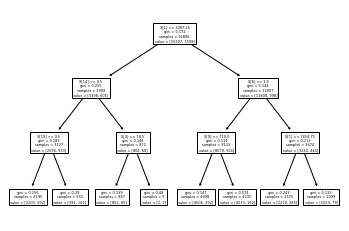

In [74]:
tree.plot_tree(clf)

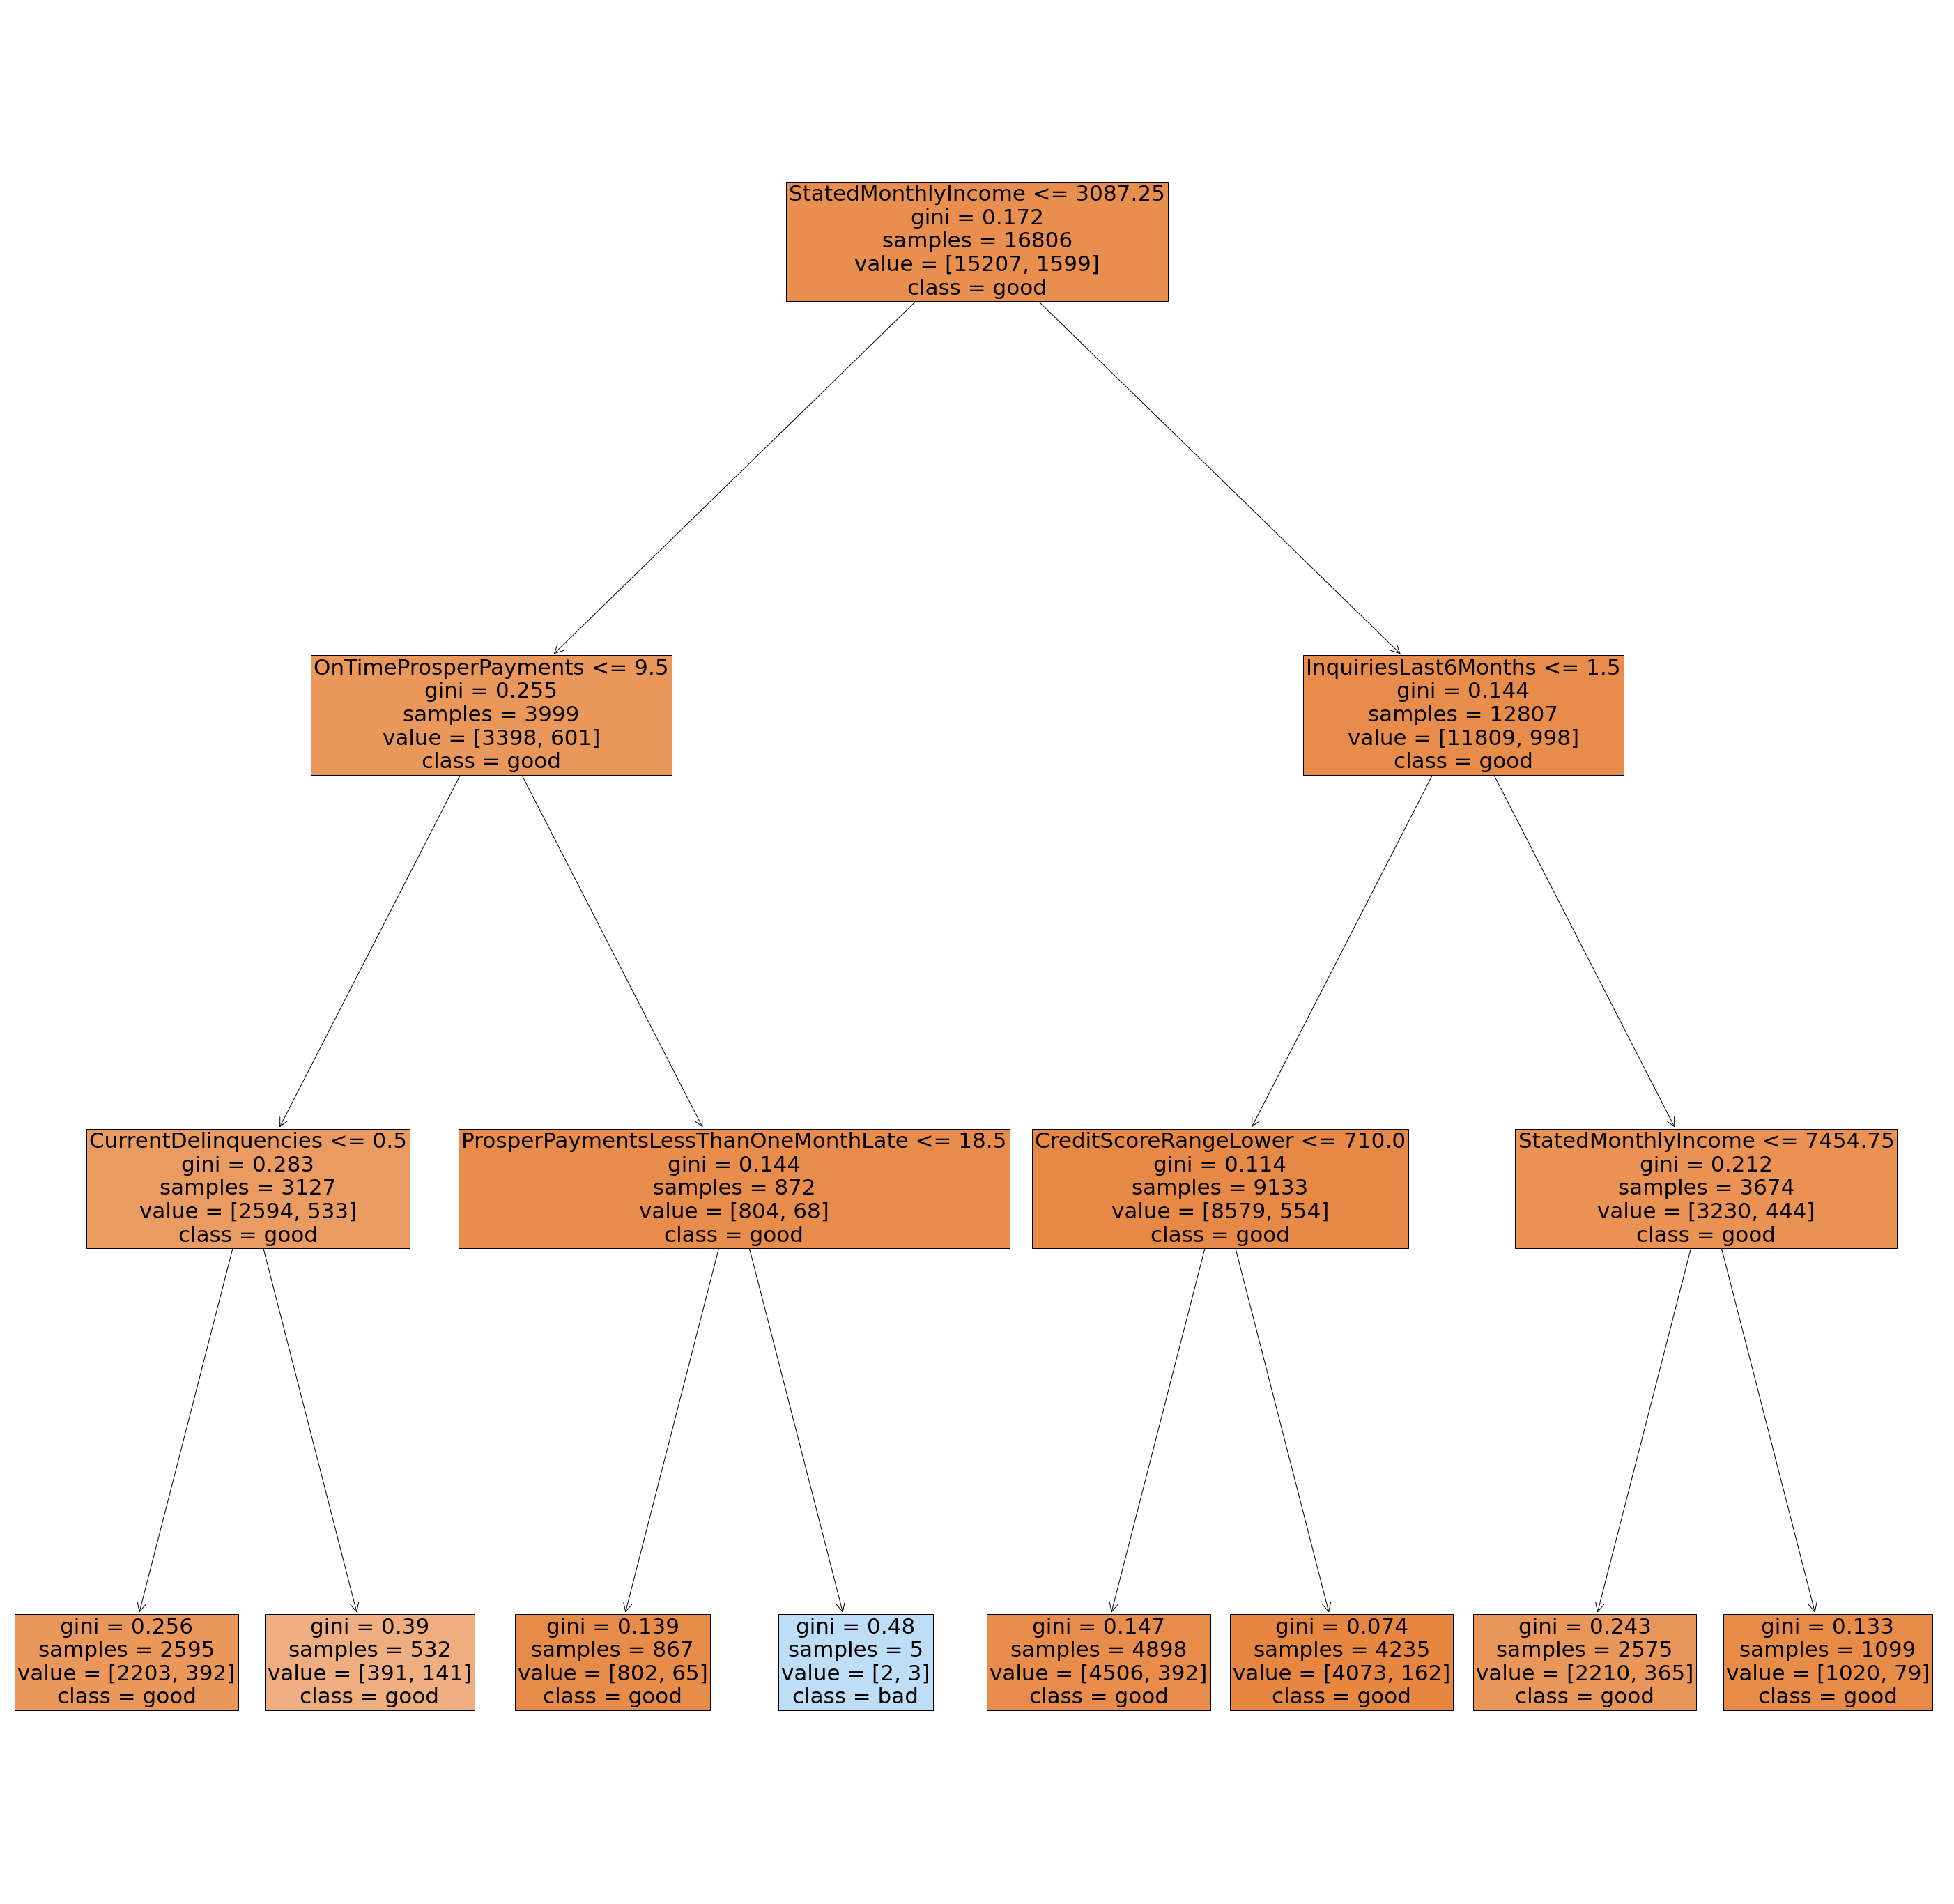

In [75]:
fig = plt.figure(figsize=(50,50))
_ = tree.plot_tree(clf, 
                   feature_names=X_tr.columns,  
                   class_names=["good","bad"],
                   fontsize=31,
                   filled=True)

In [76]:
from sklearn.feature_selection import SelectFromModel

In [77]:
from sklearn.svm import SVC

### LOFO METHOD

In [78]:
from sklearn.model_selection import KFold
from lofo import LOFOImportance, Dataset, plot_importance
%matplotlib inline
import seaborn as sns

C:\Users\jdebonil\Anaconda3\lib\site-packages\lofo\lofo_importance.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [79]:
y_tr_df=y_tr.to_frame(name='bad')

In [80]:
df_tr_preproc_rf.columns

Index(['TotalProsperLoans', 'StatedMonthlyIncome', 'ProsperPrincipalBorrowed',
       'ProsperPrincipalOutstanding', 'ProsperPaymentsLessThanOneMonthLate',
       'LoanOriginalAmount', 'InquiriesLast6Months',
       'ProsperPaymentsOneMonthPlusLate', 'CurrentCreditLines',
       'CreditScoreRangeLower', 'CurrentDelinquencies', 'TotalTrades',
       'DebtToIncomeRatio', 'TradesOpenedLast6Months', 'OnTimeProsperPayments',
       'ScorexChangeAtTimeOfListing', 'Occupation_Executive',
       'Occupation_Other', 'Occupation_Professional',
       'IncomeRange_$25,000-49,999', 'IncomeRange_$50,000-74,999',
       'IncomeRange_$75,000-99,999', 'IncomeRange_Other',
       'IncomeVerifiable_True', 'BorrowerState_FL', 'BorrowerState_NY',
       'BorrowerState_Other', 'BorrowerState_TX'],
      dtype='object')

In [81]:
df_tr_preproc_2=df_tr_preproc_rf

In [82]:
df_tr_preproc_2['bad']=y_tr_df['bad'].values

In [83]:
df_tr_preproc3=df_tr_preproc_2.drop(['bad'],axis=1)

In [84]:
from sklearn.model_selection import TimeSeriesSplit

cv = list(TimeSeriesSplit(n_splits=4).split(df_tr_preproc_2, y_tr_df["bad"]))

features = df_tr_preproc3.columns

ds = Dataset(df_tr_preproc_rf, target="bad", features=features,
    feature_groups=None,
    auto_group_threshold=1)

In [85]:
lofo_imp = LOFOImportance(ds, cv=cv, scoring="neg_mean_absolute_error")

importance_df = lofo_imp.get_importance()
importance_df

  0%|          | 0/28 [00:00<?, ?it/s]

feature  importance_mean  importance_std  \
25                     BorrowerState_FL         0.000669        0.001401   
15                 CurrentDelinquencies         0.000372        0.000324   
2                   BorrowerState_Other         0.000223        0.000531   
22                     BorrowerState_NY         0.000223        0.000644   
19              TradesOpenedLast6Months         0.000223        0.002200   
17                    DebtToIncomeRatio         0.000223        0.000902   
27                     BorrowerState_TX         0.000074        0.000609   
24           IncomeRange_$50,000-74,999         0.000074        0.001121   
20              Occupation_Professional         0.000074        0.001039   
13                 Occupation_Executive         0.000000        0.000421   
10      ProsperPaymentsOneMonthPlusLate         0.000000        0.000000   
0                     TotalProsperLoans        -0.000074        0.000851   
9                  InquiriesLast6Months        -0.000149        0.001236   
14                    IncomeRange_Other        -0.000149        0.000258   
12                CreditScoreRangeLower        -0.000223        0.000877   
6   ProsperPaymentsLessThanOneMonthLate        -0.000223        0.001286   
23                IncomeVerifiable_True        -0.000223        0.000644   
3              ProsperPrincipalBorrowed        -0.000223        0.001701   
1            IncomeRange_$25,000-49,999        -0.000298        0.000557   
5            IncomeRange_$75,000-99,999        -0.000446        0.000880   
16                          TotalTrades        -0.000446        0.001305   
21                OnTimeProsperPayments        -0.000521        0.000769   
7           ProsperPrincipalOutstanding        -0.000595        0.000842   
4                   StatedMonthlyIncome        -0.000595        0.001602   
8                    LoanOriginalAmount        -0.000669        0.001121   
26          ScorexChangeAtTimeOfListing        -0.000893        0.000210   
18                     Occupation_Other        -0.000967        0.000571   
11                   CurrentCreditLines        -0.001265        0.001080   

    val_imp_0  val_imp_1  val_imp_2  val_imp_3  
25   0.000595   0.002975  -0.000595  -0.000298  
15   0.000298   0.000298   0.000000   0.000893  
2    0.000595  -0.000298  -0.000298   0.000893  
22   0.000000   0.001190   0.000298  -0.000595  
19   0.002975   0.001785  -0.002083  -0.001785  
17  -0.000298   0.001488   0.000595  -0.000893  
27   0.000000   0.000595  -0.000893   0.000595  
24   0.001190   0.001190  -0.001190  -0.000893  
20   0.000000   0.001785  -0.000595  -0.000893  
13   0.000000   0.000000   0.000595  -0.000595  
10   0.000000   0.000000   0.000000   0.000000  
0    0.000893   0.000595  -0.001190  -0.000595  
9    0.000595   0.001488  -0.001190  -0.001488  
14   0.000000   0.000000  -0.000595   0.000000  
12   0.000595   0.000595  -0.001488  -0.000595  
6    0.000000   0.001785  -0.001488  -0.001190  
23  -0.000298   0.000595   0.000000  -0.001190  
3   -0.000595   0.002380  -0.000298  -0.002380  
1   -0.000298   0.000595  -0.000595  -0.000893  
5   -0.000893   0.000893  -0.001488  -0.000298  
16   0.000000   0.001488  -0.001785  -0.001488  
21   0.000595  -0.000298  -0.001488  -0.000893  
7   -0.000595   0.000595  -0.000595  -0.001785  
4   -0.001488   0.002083  -0.002083  -0.000893  
8    0.000000   0.000595  -0.002380  -0.000893  
26  -0.000893  -0.000595  -0.001190  -0.000893  
18  -0.000298  -0.001190  -0.001785  -0.000595  
11  -0.002083   0.000595  -0.001785  -0.001785

In [86]:
importance_df.to_excel('tabla lofo.xlsx')

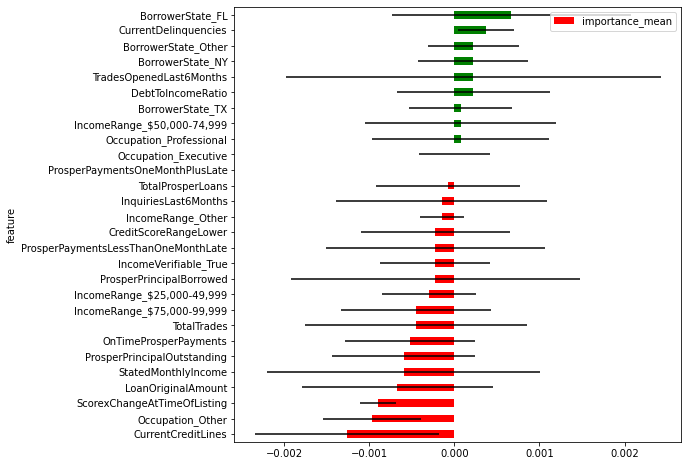

In [87]:
plot_importance(importance_df, figsize=(8, 8))

### SHAPLEY VALUES METHOD

In [88]:
import shap
explainer = shap.Explainer(rf)
shap_values = explainer(X_tr)

In [89]:
from sklearn.feature_selection import SelectFromModel

In [90]:

shap_values = shap.Explainer(rf).shap_values(X_tr)


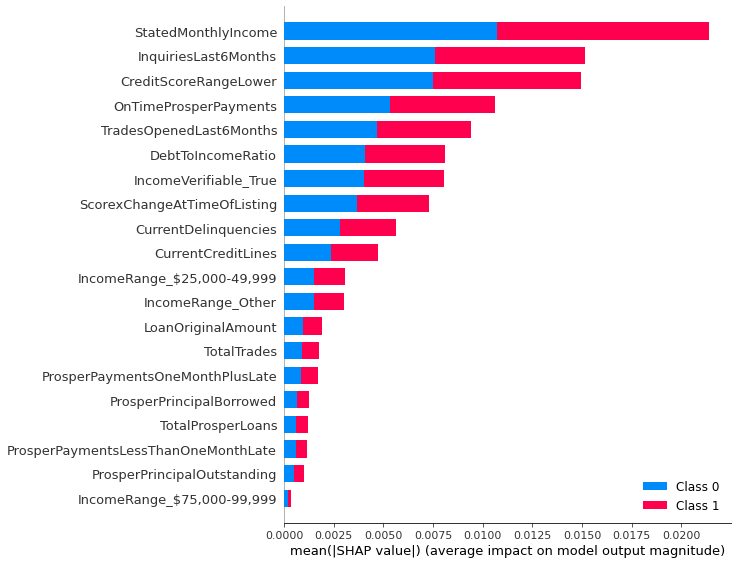

In [91]:
shap.initjs()
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(shap_values, X_tr)

In [94]:
class ShapObject:
    
    def __init__(self, base_values, data, values, feature_names):
        self.base_values = base_values # Single value
        self.data = data # Raw feature values for 1 row of data
        self.values = values # SHAP values for the same row of data
        self.feature_names = feature_names # Column names
        
idx=np.where(pred_rf_tr>0.25)
idx=idx[0]
shap_object = ShapObject(base_values = explainer.expected_value[1],
                         values = explainer.shap_values(X_tr)[1][idx,:],
                         feature_names = X_tr.columns,
                         data = X_tr.iloc[idx,:])

shap.waterfall_plot(shap_object)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [93]:
idx

array([], dtype=int64)

### FEATURE IMPORTANCE METHOD

In [93]:
feature_scores = pd.Series(rf.feature_importances_, index=X_tr.columns).sort_values(ascending=False)
feature_scores

StatedMonthlyIncome                    0.211147
InquiriesLast6Months                   0.112039
CreditScoreRangeLower                  0.100086
DebtToIncomeRatio                      0.083741
TradesOpenedLast6Months                0.079970
OnTimeProsperPayments                  0.070960
IncomeVerifiable_True                  0.061946
ScorexChangeAtTimeOfListing            0.052753
CurrentCreditLines                     0.049281
CurrentDelinquencies                   0.042649
IncomeRange_Other                      0.028370
TotalTrades                            0.018329
LoanOriginalAmount                     0.018007
IncomeRange_$25,000-49,999             0.014852
ProsperPrincipalOutstanding            0.013292
ProsperPrincipalBorrowed               0.010333
ProsperPaymentsOneMonthPlusLate        0.009440
ProsperPaymentsLessThanOneMonthLate    0.008664
TotalProsperLoans                      0.006431
IncomeRange_$75,000-99,999             0.002880
Occupation_Other                       0

In [94]:
df_=pd.DataFrame()

df_['Features']=feature_scores.index
df_['Importance']=feature_scores.values

In [96]:
df_.to_excel('d1facmabiar.xlsx')

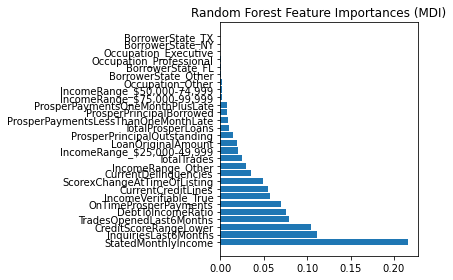

In [96]:
y_ticks = np.arange(0, len(feature_scores.index))
fig, ax = plt.subplots()
ax.barh(y_ticks, feature_scores.values)
ax.set_yticks(y_ticks)
ax.set_yticklabels(feature_scores.index)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

### END CODE